# Capstone Udacity Project

## Fraud Detection based on a simulated dataset by PaySim 

(dataset: https://www.kaggle.com/ealaxi/paysim1)

in this project we are working on finding the model that best 
fits our dataset in terms of classifying a transaction as fraudulent or geniune

In [1]:
# installations needed
! pip install seaborn==0.9.0

    100% |████████████████████████████████| 215kB 11.1MB/s ta 0:00:01  19% |██████▎                         | 40kB 8.2MB/s eta 0:00:01
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1


In [2]:
# labrary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# libraries for data cleaning part
from engine.utilities import *
from engine.dataCleaning import *
# libraries for modelling part
from engine.modelingPreparation import *
from engine.modelsComparison import *
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


# expand cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# REPORT FOR CLEANING DATA

### data cleaning and adding measures

In [3]:
# instasiate data_cleaning class
dc = data_cleaning()

# read data
data = dc.data_reading('PS_20174392719_1491204439457_log.csv')

# drop duplicate and missing values
# during exploration it was found that no duplicate values exist in the dataset
# during exploration there was a record that had only 4 out othe total columns. 
  # also the target variable was missing, so this record is dropped
data = dc.drop_miss_dublicates(data)

# identify the type of the counterparties and exatract it. Entities can only be customer or merchants
data = dc.cust_merch_ind(data)

# calculate the frequency each entity appears in the originator and destination positions
# these measure will be used as inputs for the models
data = dc.orig_entity_position_freq(data)
data = dc.dest_entity_position_freq(data)

data reading...
dataset initial shape: (4693572, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0.000,0.000
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0.000,0.000
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1.000,0.000
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1.000,0.000
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0.000,0.000


show basic stats...


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,4693572.000,4693572.000,4693572.000,4693572.000,4693571.000,4693571.000,4693571.000,4693571.000
mean,181.574,180175.021,840375.260,862111.769,1053693.336,1184523.670,0.001,0.000
std,99.363,652119.942,2913602.980,2950268.710,2996798.067,3371071.491,0.028,0.001
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,132.000,13097.843,0.000,0.000,0.000,0.000,0.000,0.000
50%,189.000,75691.155,14057.000,0.000,136790.200,220114.430,0.000,0.000
75%,259.000,209478.315,107915.000,146472.955,944709.845,1118495.210,0.000,0.000
max,331.000,92445516.640,43818855.300,43686616.330,355553416.300,355553416.300,1.000,1.000
skew,-0.386,32.203,5.216,5.147,18.535,19.104,35.454,1250.808
mad,82.473,181930.825,1377251.685,1408640.286,1344363.094,1463311.662,0.002,0.000


date: 02/02/2022   runtime: 0:00:21.510535

duplicate values can cause noise in the data. Thus checking if there are any and dropping them
no duplicates
date: 02/02/2022   runtime: 0:00:14.060442

getting the Customer and Merchant indicators
date: 02/02/2022   runtime: 0:00:02.911365
ORIG ENTITY: originator frequencies...
ORIG ENTITY: destination frequencies...
add originator frequencies to final table...
date: 02/02/2022   runtime: 0:01:51.625955
DEST ENTITY: originator frequencies...
DEST ENTITY: destination frequencies...
add destination frequencies to final table...
date: 02/02/2022   runtime: 0:02:27.474475


### data insights

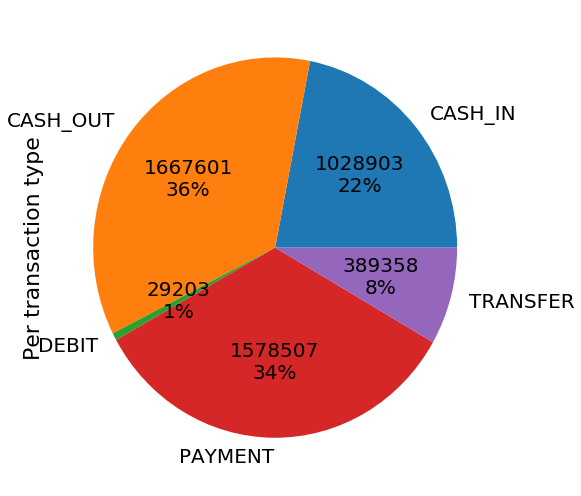

In [7]:
def label_function(val):
    return f'{val / 100 * len(data):.0f}\n{val:.0f}%'


fig, ax = plt.subplots(figsize=(7, 7))

data.groupby('type').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20}, ax=ax)

ax.set_ylabel('Per transaction type', size=22)
plt.tight_layout()
plt.show()

In [4]:
df = data[['origEntity_trxCnt_origPos','origEntity_trxCnt_destPos','origEntity_trxCnt','destEntity_trxCnt_destPos','destEntity_trxCnt_origPos','destEntity_trxCnt','isFraud']]
df['direction_or'] = np.where(df['origEntity_trxCnt'] == 1, 'O1','On')
df['direction_ds'] = np.where(df['destEntity_trxCnt'] == 1, 'D1','Dn')
df['direction'] = df['direction_or']+df['direction_ds']

df.groupby('direction').agg({'isFraud':['count','sum']})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

isFraud         
             count      sum
direction                  
O1D1       1655356  512.000
O1Dn       3026914 3205.000
OnD1          3991    3.000
OnDn          7310    5.000

In [8]:
# data exploration to see how it looks like and what can be inferred by the data


# show the min/max values of different numberic values to understand the data
print("min/max of amount, old balance Orgi and Dest per type")
agg_functions = ['min','max']
data[['type','amount','oldbalanceOrg','oldbalanceDest']].groupby(['type']).agg({'amount':agg_functions
                                                                               ,'oldbalanceOrg':agg_functions
                                                                               ,'oldbalanceDest':agg_functions})
print("RESULT: the volumes have very broad ranges.\n ")

print("min/max or count/sum of amount, old balance Orgi and Dest per type and fraud target flag ")
agg_functions = ['min','max']
display(data[['type','isFraud','amount','oldbalanceOrg','oldbalanceDest']].groupby(['type','isFraud']).agg({'amount':agg_functions
                                                                               ,'oldbalanceOrg':agg_functions
                                                                               ,'oldbalanceDest':agg_functions
                                                                               ,'isFraud':['count','sum']}))

print("RESULT: the count of Fraudulent transactions shows that they appear in 'CASH OUT' and 'TRANSFER' transaction types only \n")


print("min/max or count/sum of amount, old balance Orgi and Dest per type of Originator and Destination and Fraud Flag")
display(data[['ext_org_ind','ext_den_ind','isFraud','amount','oldbalanceOrg','oldbalanceDest']].groupby(['ext_org_ind','ext_den_ind','isFraud']).agg({'amount':agg_functions
                                                                               ,'oldbalanceOrg':agg_functions
                                                                               ,'oldbalanceDest':agg_functions
                                                                               ,'isFraud':['count','sum']}))
print("RESULT: the count of Fraudulent transactions shows that only when customers in a transaction are involved cause fraudulent transactions \n")


print("min/max or count/sum of amount, old balance Orgi and Dest per type of Originator and Destination, transaction type and Fraud Flag")
display(data[['type','ext_org_ind','ext_den_ind','isFraud','amount','oldbalanceOrg','oldbalanceDest']].groupby(['type','ext_org_ind','ext_den_ind','isFraud']).agg({'amount':agg_functions
                                                                               ,'oldbalanceOrg':agg_functions
                                                                               ,'oldbalanceDest':agg_functions
                                                                               ,'isFraud':['count','sum']}))
print("RESULT: the count of Fraudulent transactions shows that they appear in 'CASH OUT' and 'TRANSFER' transaction types only,\nand on top any 'PAYMENT' transactions do not have Balance of destination as expected  \n")


min/max of amount, old balance Orgi and Dest per type
RESULT: the volumes have very broad ranges.
 
min/max or count/sum of amount, old balance Orgi and Dest per type and fraud target flag 


amount              oldbalanceOrg               \
                     min          max           min          max   
type     isFraud                                                   
CASH_IN  0.000     0.960  1915267.900         0.000 38939424.030   
CASH_OUT 0.000     0.370  2847566.620         0.000 43818855.300   
         1.000     0.000 10000000.000         0.000 10000000.000   
DEBIT    0.000     0.550   569077.510         0.000  4362014.110   
PAYMENT  0.000     0.020   197201.170         0.000 43686616.330   
TRANSFER 0.000     2.600 92445516.640         0.000 25908675.060   
         1.000   119.000 10000000.000         0.000 37670038.080   

                 oldbalanceDest                isFraud           
                            min           max    count      sum  
type     isFraud                                                 
CASH_IN  0.000            0.000 355553416.300  1028902    0.000  
CASH_OUT 0.000            0.000 311404901.410  1665729    0.000  
         1.000            0.000  32961658.250     1872 1872.000  
DEBIT    0.000          221.000 235951203.460    29203    0.000  
PAYMENT  0.000            0.000         0.000  1578507    0.000  
TRANSFER 0.000            0.000 324915061.410   387505    0.000  
         1.000            0.000   2122336.550     1853 1853.000

RESULT: the count of Fraudulent transactions shows that they appear in 'CASH OUT' and 'TRANSFER' transaction types only 

min/max or count/sum of amount, old balance Orgi and Dest per type of Originator and Destination and Fraud Flag


amount              oldbalanceOrg  \
                                   min          max           min   
ext_org_ind ext_den_ind isFraud                                     
C           C           0.000    0.370 92445516.640         0.000   
                        1.000    0.000 10000000.000         0.000   
            M           0.000    0.020   197201.170         0.000   

                                             oldbalanceDest                \
                                         max            min           max   
ext_org_ind ext_den_ind isFraud                                             
C           C           0.000   43818855.300          0.000 355553416.300   
                        1.000   37670038.080          0.000  32961658.250   
            M           0.000   43686616.330          0.000         0.000   

                                 isFraud           
                                   count      sum  
ext_org_ind ext_den_ind isFraud                    
C           C           0.000    3111339    0.000  
                        1.000       3725 3725.000  
            M           0.000    1578507    0.000

RESULT: the count of Fraudulent transactions shows that only when customers in a transaction are involved cause fraudulent transactions 

min/max or count/sum of amount, old balance Orgi and Dest per type of Originator and Destination, transaction type and Fraud Flag


amount              oldbalanceOrg  \
                                             min          max           min   
type     ext_org_ind ext_den_ind isFraud                                      
CASH_IN  C           C           0.000     0.960  1915267.900         0.000   
CASH_OUT C           C           0.000     0.370  2847566.620         0.000   
                                 1.000     0.000 10000000.000         0.000   
DEBIT    C           C           0.000     0.550   569077.510         0.000   
PAYMENT  C           M           0.000     0.020   197201.170         0.000   
TRANSFER C           C           0.000     2.600 92445516.640         0.000   
                                 1.000   119.000 10000000.000         0.000   

                                                      oldbalanceDest  \
                                                  max            min   
type     ext_org_ind ext_den_ind isFraud                               
CASH_IN  C           C           0.000   38939424.030          0.000   
CASH_OUT C           C           0.000   43818855.300          0.000   
                                 1.000   10000000.000          0.000   
DEBIT    C           C           0.000    4362014.110        221.000   
PAYMENT  C           M           0.000   43686616.330          0.000   
TRANSFER C           C           0.000   25908675.060          0.000   
                                 1.000   37670038.080          0.000   

                                                        isFraud           
                                                   max    count      sum  
type     ext_org_ind ext_den_ind isFraud                                  
CASH_IN  C           C           0.000   355553416.300  1028902    0.000  
CASH_OUT C           C           0.000   311404901.410  1665729    0.000  
                                 1.000    32961658.250     1872 1872.000  
DEBIT    C           C           0.000   235951203.460    29203    0.000  
PAYMENT  C           M           0.000           0.000  1578507    0.000  
TRANSFER C           C           0.000   324915061.410   387505    0.000  
                                 1.000     2122336.550     1853 1853.000

RESULT: the count of Fraudulent transactions shows that they appear in 'CASH OUT' and 'TRANSFER' transaction types only,
and on top any 'PAYMENT' transactions do not have Balance of destination as expected  



### add balance checks


Check balances for Orig...
update old and new balances to reflect missing data...


/home/workspace/fraud_data_project/engine/dataCleaning.py:114: RuntimeWarning: divide by zero encountered in log10
  np.where(data['Error_newbalance{}'.format(direction)] == 0  , -1, np.log10(data['Error_newbalance{}'.format(direction)])))
/home/workspace/fraud_data_project/engine/dataCleaning.py:114: RuntimeWarning: invalid value encountered in log10
  np.where(data['Error_newbalance{}'.format(direction)] == 0  , -1, np.log10(data['Error_newbalance{}'.format(direction)])))


calculate difference of existinct and re-calcualted final balances...


isFraud         
                                              count      sum
recalc_vs_df_newbalance_Orig                                
correct - equals                              22314 3649.000
missing                                          89    3.000
missing data - not talking negative values  1551597   25.000
wrong                                       3119571   48.000

isFraud           \
                                                      count      sum   
recalc_vs_df_newbalance_Orig               type                        
correct - equals                           CASH_OUT    3607 1847.000   
                                           TRANSFER    1954 1802.000   
missing                                    CASH_OUT       4    0.000   
                                           TRANSFER       4    3.000   
missing data - not talking negative values CASH_OUT  772300   21.000   
                                           TRANSFER  207357    4.000   
wrong                                      CASH_OUT  891690    4.000   
                                           TRANSFER  180043   44.000   

                                                        amount               \
                                                           min          max   
recalc_vs_df_newbalance_Orig               type                               
correct - equals                           CASH_OUT      0.000 10000000.000   
                                           TRANSFER    119.000  9977761.050   
missing                                    CASH_OUT      0.370   144659.770   
                                           TRANSFER 169106.970  4953893.080   
missing data - not talking negative values CASH_OUT      1.580  2847566.620   
                                           TRANSFER      2.600 92445516.640   
wrong                                      CASH_OUT      1.390  1073354.830   
                                           TRANSFER      3.320 57787800.930   

                                                    newbalanceOrig  \
                                                               min   
recalc_vs_df_newbalance_Orig               type                      
correct - equals                           CASH_OUT          0.000   
                                           TRANSFER          0.000   
missing                                    CASH_OUT      10041.210   
                                           TRANSFER     536624.410   
missing data - not talking negative values CASH_OUT          0.000   
                                           TRANSFER          0.000   
wrong                                      CASH_OUT          0.000   
                                           TRANSFER          0.000   

                                                                  
                                                             max  
recalc_vs_df_newbalance_Orig               type                   
correct - equals                           CASH_OUT  3681137.000  
                                           TRANSFER  3122125.000  
missing                                    CASH_OUT   149735.970  
                                           TRANSFER  4953893.080  
missing data - not talking negative values CASH_OUT        0.000  
                                           TRANSFER        0.000  
wrong                                      CASH_OUT 43686616.330  
                                           TRANSFER 27670038.080

distributions...
NO FRAUD


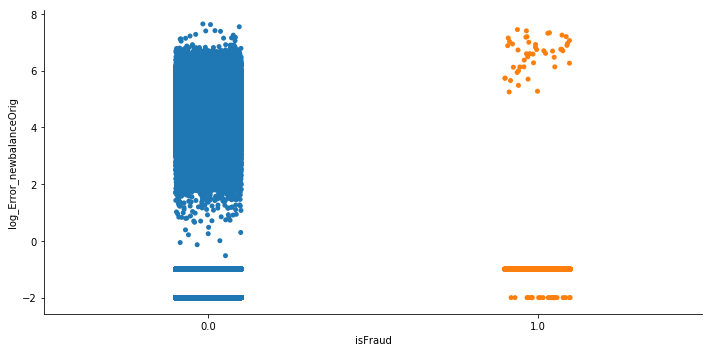

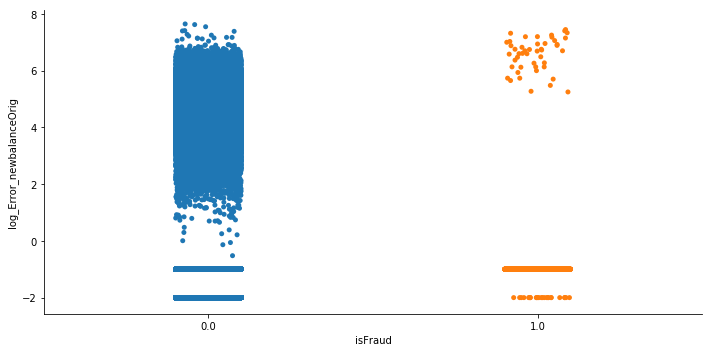

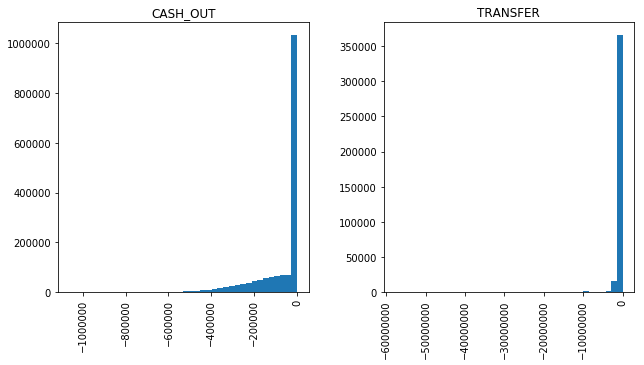

FRAUD


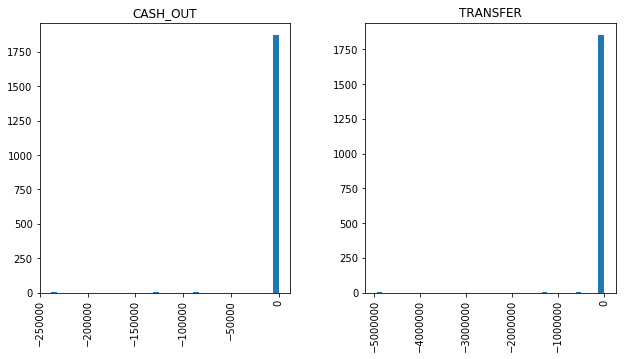

date: 02/02/2022   runtime: 0:06:51.077454

Check balances for Dest...
update old and new balances to reflect missing data...
calculate difference of existinct and re-calcualted final balances...


isFraud         
                                              count      sum
recalc_vs_df_newbalance_Dest                                
correct - equals                                  2    2.000
missing                                           2    1.000
missing data - not talking negative values  1697575 1826.000
wrong                                       2995992 1896.000

isFraud           amount  \
                                                       count      sum     min   
recalc_vs_df_newbalance_Dest               type                                 
correct - equals                           CASH_OUT        2    2.000   0.000   
missing                                    CASH_OUT        1    1.000   0.000   
missing data - not talking negative values CASH_OUT     1503    2.000   0.370   
                                           TRANSFER     1929 1824.000 119.000   
wrong                                      CASH_OUT  1666095 1867.000   1.000   
                                           TRANSFER   387429   29.000   2.600   

                                                                  \
                                                             max   
recalc_vs_df_newbalance_Dest               type                    
correct - equals                           CASH_OUT        0.000   
missing                                    CASH_OUT        0.000   
missing data - not talking negative values CASH_OUT   649399.780   
                                           TRANSFER 10000000.000   
wrong                                      CASH_OUT 10000000.000   
                                           TRANSFER 92445516.640   

                                                    newbalanceDest  \
                                                               min   
recalc_vs_df_newbalance_Dest               type                      
correct - equals                           CASH_OUT          0.000   
missing                                    CASH_OUT     538547.630   
missing data - not talking negative values CASH_OUT          0.000   
                                           TRANSFER          0.000   
wrong                                      CASH_OUT          0.000   
                                           TRANSFER          0.000   

                                                                   
                                                              max  
recalc_vs_df_newbalance_Dest               type                    
correct - equals                           CASH_OUT         0.000  
missing                                    CASH_OUT    538547.630  
missing data - not talking negative values CASH_OUT         0.000  
                                           TRANSFER         0.000  
wrong                                      CASH_OUT 311492902.800  
                                           TRANSFER 355553416.300

distributions...
NO FRAUD


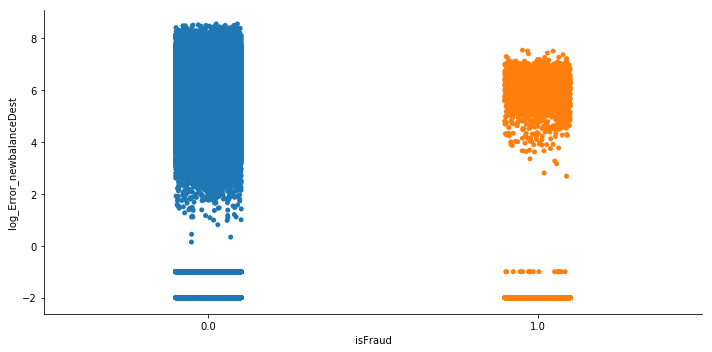

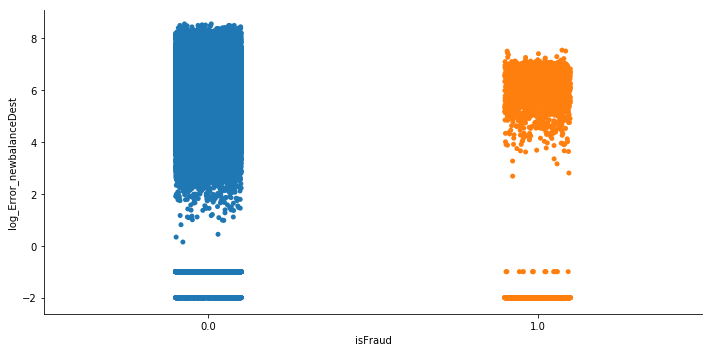

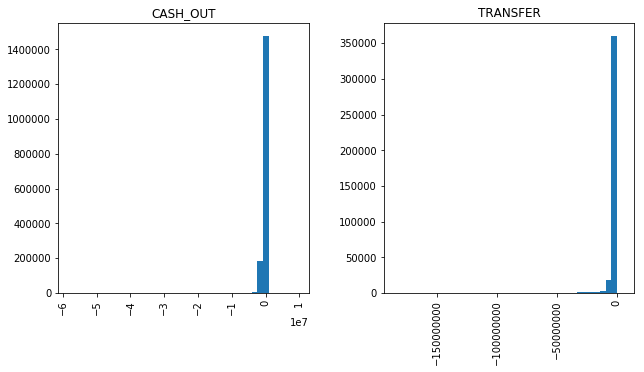

FRAUD


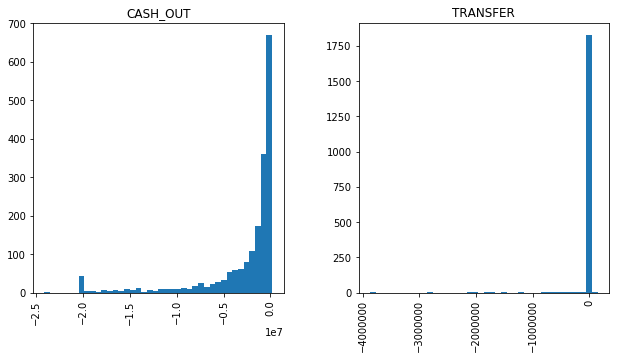

date: 02/02/2022   runtime: 0:12:52.057148


In [4]:
# check the old and new balances of the originator and destination.
# if both new and old balances or originator are equal to 0 then this is considered a missing point and is marked as -1
# same process for the destination. 
# below method also provides insights on the data based of these extra measures
data = dc.check_balances('Orig', 'oldbalanceOrg', 'newbalanceOrig', data)
data = dc.check_balances('Dest', 'oldbalanceDest', 'newbalanceDest', data)

In [5]:
# check table
print("\nData table after add-ons...")
display(data.head())


Data table after add-ons...


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,ext_org_ind,ext_den_ind,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,origEntity_trxCnt,destEntity_trxCnt_destPos,destEntity_trxCnt_origPos,destEntity_trxCnt,Error_oldbalanceOrig,Error_newbalanceOrig,log_Error_newbalanceOrig,Error_Orig_fnlBlnce,diff_Orig_fnl_balance,recalc_vs_df_newbalance_Orig,Error_oldbalanceDest,Error_newbalanceDest,log_Error_newbalanceDest,Error_Dest_fnlBlnce,diff_Dest_fnl_balance,recalc_vs_df_newbalance_Dest
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0.000,0.000,C,M,1,nan,1,1,nan,1,170136.000,160296.360,5.205,160296.360,0.000,wrong,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0.000,0.000,C,M,1,nan,1,1,nan,1,21249.000,19384.720,4.287,19384.720,0.000,wrong,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1.000,0.000,C,C,1,nan,1,39,nan,39,181.000,0.000,-1.000,0.000,0.000,correct - equals,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1.000,0.000,C,C,1,nan,1,38,nan,38,181.000,0.000,-1.000,0.000,0.000,correct - equals,21182.000,0.000,-1.000,21001.000,21001.000,wrong
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0.000,0.000,C,M,1,nan,1,1,nan,1,41554.000,29885.860,4.475,29885.860,0.000,wrong,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values


### amount insights and checks

,amount
count,3.000
sum,0.000
,amount
count,93.000
sum,42.530
,amount
count,0.000
sum,0.000


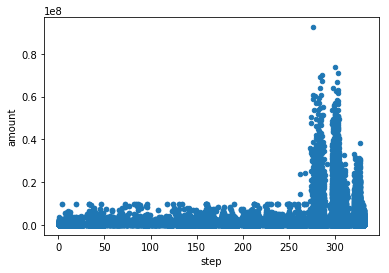

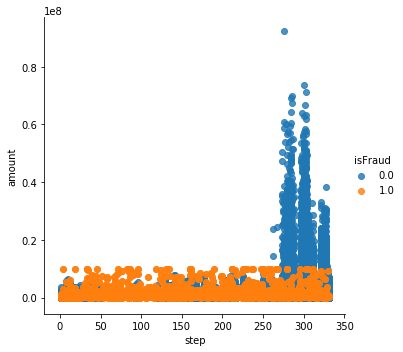

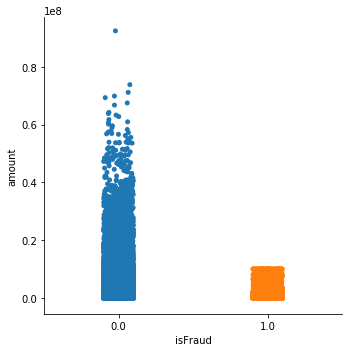

In [6]:
# check transactional amount in case there are errors
# plot amount over time, per fraud flag and value
# check amount (zero values + scatter plot + candle plot)
display_side_by_side(data.loc[data['amount'] == 0].agg({'amount':['count','sum']})
                    ,data.loc[(data['amount'] >= -1) & (data['amount'] <= 1)].agg({'amount':['count','sum']})
                    ,data.loc[(data['amount'] <0) ].agg({'amount':['count','sum']})
                    ,titles = [" amount == 0", """adding weird rounds to the 0 values \n(data['amount'] >= -1) & (data['amount'] <= 1)""", """\namount negative values"""])



data.plot.scatter(x='step',y='amount')
sns.lmplot(x='step',y='amount', data=data, hue='isFraud', fit_reg=False)
sns.catplot(x="isFraud", y="amount", data=data)

### dummy variables creation

In [7]:
# finally add dummy variables to the dataset for the transaction types and the customer/merchant indicator
# this is useful input for the modelling part
data = dc.dummy_variables(data)

add dummy variables of categorical columns...


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,origEntity_trxCnt,destEntity_trxCnt_destPos,destEntity_trxCnt_origPos,destEntity_trxCnt,Error_oldbalanceOrig,Error_newbalanceOrig,log_Error_newbalanceOrig,Error_Orig_fnlBlnce,diff_Orig_fnl_balance,recalc_vs_df_newbalance_Orig,Error_oldbalanceDest,Error_newbalanceDest,log_Error_newbalanceDest,Error_Dest_fnlBlnce,diff_Dest_fnl_balance,recalc_vs_df_newbalance_Dest,PAYMENT,TRANSFER,CASH_OUT,CASH_IN,ext_org_ind_C,ext_den_ind_C
0,1,PAYMENT,9839.640,170136.000,160296.360,0.000,0.000,0.000,0.000,1,nan,1,1,nan,1,170136.000,160296.360,5.205,160296.360,0.000,wrong,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values,1,0,0,0,1,0
1,1,PAYMENT,1864.280,21249.000,19384.720,0.000,0.000,0.000,0.000,1,nan,1,1,nan,1,21249.000,19384.720,4.287,19384.720,0.000,wrong,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values,1,0,0,0,1,0
2,1,TRANSFER,181.000,181.000,0.000,0.000,0.000,1.000,0.000,1,nan,1,39,nan,39,181.000,0.000,-1.000,0.000,0.000,correct - equals,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values,0,1,0,0,1,1
3,1,CASH_OUT,181.000,181.000,0.000,21182.000,0.000,1.000,0.000,1,nan,1,38,nan,38,181.000,0.000,-1.000,0.000,0.000,correct - equals,21182.000,0.000,-1.000,21001.000,21001.000,wrong,0,0,1,0,1,1
4,1,PAYMENT,11668.140,41554.000,29885.860,0.000,0.000,0.000,0.000,1,nan,1,1,nan,1,41554.000,29885.860,4.475,29885.860,0.000,wrong,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values,1,0,0,0,1,0


date: 02/02/2022   runtime: 0:00:07.983768


### save dataset

In [8]:
# save cleaned dataset with new dimensions to save time in case it needs to be used multiple times for the modelling part
dc.save_clean_df(data)

save dataset...
file is saved as:  datasetFraud_variables_20220203.csv
date: 02/02/2022   runtime: 0:02:51.953753


# Modelling of fraud dataset

### prepare dataset for modelling

In [2]:
# read existing clean dataset
# fill in any null values in case there is anything in the future
# create flags to identify the outliers and use them in the modelling part
mp = modeling_preparation()
data= mp.run()

file that will be used for this run is: datasetFraud_variables_20220203.csv
reading file...
filling N/A...


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,origEntity_trxCnt,destEntity_trxCnt_destPos,destEntity_trxCnt_origPos,destEntity_trxCnt,Error_oldbalanceOrig,Error_newbalanceOrig,log_Error_newbalanceOrig,Error_Orig_fnlBlnce,diff_Orig_fnl_balance,recalc_vs_df_newbalance_Orig,Error_oldbalanceDest,Error_newbalanceDest,log_Error_newbalanceDest,Error_Dest_fnlBlnce,diff_Dest_fnl_balance,recalc_vs_df_newbalance_Dest,PAYMENT,TRANSFER,CASH_OUT,CASH_IN,ext_org_ind_C,ext_den_ind_C
0,1,PAYMENT,9839.640,170136.000,160296.360,0.000,0.000,0.000,0.000,1,0.000,1,1,0.000,1,170136.000,160296.360,5.205,160296.360,0.000,wrong,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values,1,0,0,0,1,0
1,1,PAYMENT,1864.280,21249.000,19384.720,0.000,0.000,0.000,0.000,1,0.000,1,1,0.000,1,21249.000,19384.720,4.287,19384.720,0.000,wrong,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values,1,0,0,0,1,0
2,1,TRANSFER,181.000,181.000,0.000,0.000,0.000,1.000,0.000,1,0.000,1,39,0.000,39,181.000,0.000,-1.000,0.000,0.000,correct - equals,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values,0,1,0,0,1,1
3,1,CASH_OUT,181.000,181.000,0.000,21182.000,0.000,1.000,0.000,1,0.000,1,38,0.000,38,181.000,0.000,-1.000,0.000,0.000,correct - equals,21182.000,0.000,-1.000,21001.000,21001.000,wrong,0,0,1,0,1,1
4,1,PAYMENT,11668.140,41554.000,29885.860,0.000,0.000,0.000,0.000,1,0.000,1,1,0.000,1,41554.000,29885.860,4.475,29885.860,0.000,wrong,-1.000,-1.000,-2.000,-1.000,-1.000,missing data - not talking negative values,1,0,0,0,1,0


date: 03/02/2022   runtime: 0:00:24.123759
calculate z-score...
creating flag to identify outliers in the dataset...
check z-score outlier result


z_outlier  isFraud
0          0.000      4429706
           1.000         2985
1          0.000        75692
           1.000          602
2          0.000       161809
           1.000           77
3          0.000        19291
           1.000           60
4          0.000         2829
           1.000            1
5          0.000          519
Name: amount, dtype: int64

date: 03/02/2022   runtime: 0:01:30.888601
calculate Q1,Q3,IQR...
calculate iqr_outlier...
merge outlier result to data...
check iqr outlier result


iqr_outlier  isFraud
0            0.000      3015180
             1.000         1423
1            0.000       423102
             1.000          513
2            0.000       902989
             1.000         1207
3            0.000       178472
             1.000          505
4            0.000       142132
             1.000           68
5            0.000        26973
             1.000            9
6            0.000          997
7            0.000            1
Name: amount, dtype: int64

date: 03/02/2022   runtime: 0:01:23.591995


### apply and compare different models

spliting data to variables(x) and target(y)...
spliting data to train and test...
date: 03/02/2022   runtime: 0:00:43.105321


instansiate model 'Logistic Regression' ...
model fitting...
model accuracy for trained data = 0.9993122506873232
get importance...
importance function diffes for the specific model
predictions and probs on test dataset...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


calculate metrics...
calculate cross-validation...


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Store metrics...
date: 03/02/2022   runtime: 0:14:32.625527


instansiate model 'Decision Tree' ...
model fitting...
model accuracy for trained data = 0.9996832546535999
get importance...


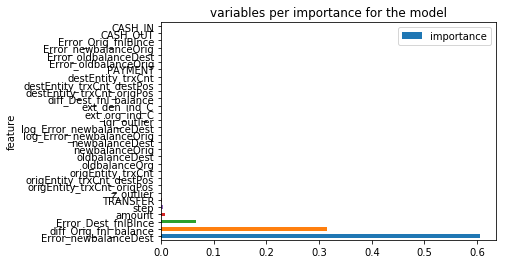

predictions and probs on test dataset...
calculate metrics...
calculate cross-validation...
Store metrics...
date: 03/02/2022   runtime: 0:03:04.069896


instansiate model 'Random Forest' ...
model fitting...
model accuracy for trained data = 0.9999991477703685
get importance...


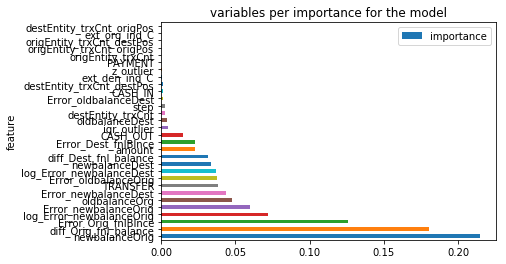

predictions and probs on test dataset...
calculate metrics...
calculate cross-validation...
Store metrics...
date: 03/02/2022   runtime: 0:07:09.049921


instansiate model 'TWO CLASS BAYES' ...
model fitting...
model accuracy for trained data = 0.9918319471344915
get importance...
importance function diffes for the specific model
predictions and probs on test dataset...
calculate metrics...
calculate cross-validation...
Store metrics...
date: 03/02/2022   runtime: 0:00:41.874803


,model,accuracy,precision,recall,f1,cv_precision
2,Random Forest,1.000,1.000,0.992,0.996,0.999
1,Decision Tree,1.000,0.941,0.611,0.741,0.962
0,Logistic Regression,0.999,0.816,0.210,0.335,0.551
3,TWO CLASS BAYES,0.992,0.038,0.384,0.068,0.053


In [10]:
# choose the models to apply and compare on the trained dataset and check their accuracy and precision
# choose the best performing model for the next section
models_cons = {'Logistic Regression': LogisticRegression()
              ,'Decision Tree'      : tree.DecisionTreeClassifier(max_depth=3)
              ,'Random Forest'      : RandomForestClassifier()
              ,'TWO CLASS BAYES'    : GaussianNB()}

mc = models_comparison(data,models_cons,'isFraud')
mc.run()

### apply and save the best performing model

In [11]:
mc.run_save_model({'title':'Random Forest', 'model': RandomForestClassifier()})

CHOSEN MODEL: Random Forest
# Create x and y from all data...
# Re-train model on all data...
# Save model pickle file classifier_20220203.pkl
date: 03/02/2022   runtime: 0:04:59.178732


# *****End of Script*****